# [NTDS'18] Team project
[ntds'18]: https://github.com/mdeff/ntds_2018

## Students

* Team: `<34>`
* Students: `<Valentin Morel, Xavier Sieber, Cédric Schumacher, Charles-Théophile Coen>`
* Dataset: `<Terrorist attack>`

In [1]:
%matplotlib inline

import numpy as np
import networkx as nx
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers

In [2]:
## Loading of files

# Features: mean of 126; std of 149
features = np.load('features_matrix.npy')

# Labels
labels =  np.load('labels_vector.npy')

# Location
adjacency_location = np.load('adjacency_location.npy')
n_nodes = len(adjacency_location)
location = np.load('location_vector.npy')

# Weighted adjacency matrix of the distance from features
adjacency_weights = np.load('adjacency_weights_matrix.npy')

In [3]:
## Definition of fonctions

def distance_weighted(i,j):
    return adjacency_weights[i,j]

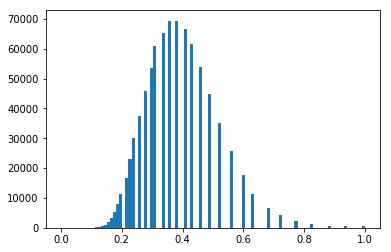

In [4]:
# Visualization of the distrubution of the distances of features
weights_hist = np.zeros(int(n_nodes*(n_nodes-1)/2))
n = 0
for i in range(0,n_nodes):
    for j in range(i+1,n_nodes):
        weights_hist[n] = adjacency_weights[i,j]
        n += 1
plt.hist(weights_hist, bins = np.linspace(0,1,100))   
plt.show()

##### **Remarks**
The adjacency_weights matrix allow us to picture the difference between two features. The smaller the value between two node's features the more similar they are in terms of their features.

In [5]:
unique_ele, unique_indices, unique_counts = np.unique(location, return_index = True, return_counts = True)
mapping = {}
for i in range(0,len(unique_ele)):
    if unique_counts[i] > 1:
        mapping[unique_ele[i]] = {'numbers':unique_counts[i], 'indices':np.where(location == unique_ele[i])[0]}
        

# List of keys of the dictionnary
keys = list(mapping.keys())
# List of values of dict containing numbers and indices of nodes with the same location
values = list(mapping.values()) 
# List of all the indexes of locations with more than one attack
index_attack = []
for i in range(0,len(keys)):
    index_attack.append(list(mapping[keys[i]]['indices']))
    
index_attack = [val for sublist in index_attack for val in sublist]   

In [6]:
weights_dict = {}
for i in keys:
    num_nodes_same_loc = mapping[i]['numbers']
    distances = np.zeros(int((num_nodes_same_loc)*(num_nodes_same_loc-1)/2))
    index = 0
    for j in range(0,num_nodes_same_loc):
        for k in range(j+1,num_nodes_same_loc):
            distances[index] = distance_weighted(mapping[i]['indices'][j],mapping[i]['indices'][k])
            index += 1

    weights_dict[i] = {'distances':distances, 'mean': np.mean(distances), 'std': np.std(distances)}

In [7]:
labels_dict = {}
for i in keys:
    num_nodes_same_loc = mapping[i]['numbers']
    lab = []
    for j in range(0,num_nodes_same_loc):
        lab.append(labels[mapping[i]['indices'][j]][0])

    labels_dict[i] = lab

recap_label = {}
for i in keys:
    unique_ele, unique_counts = np.unique(labels_dict[i], return_counts = True)
    total_attacks = mapping[i]['numbers']
    list_attacks = [];
    for j in range(0,len(unique_ele)):
        list_attacks.append({unique_ele[j]: np.round(unique_counts[j]/total_attacks*100)})

    list_attacks.append(total_attacks)
    recap_label[i] =  list_attacks

##### **Remarks**
The *mapping* dictionary contains the locations where multiple attacks were perpetrated. For each location, the number of attacks(n) is specified and the indices of the nodes are stored in an array.

The *weights_dict* dictionary contains the weighted distance in terms of features between every attacks perpetrated at the same location. The distances are stored in an array of *(n-1)n/2* values where n is the number of attacks at this location. The goal of this dictionary is to find any links between the colocated attacks and their features.

The *labels_dict* dictionary contains the type of attacks for the attacks perpetrated at the same location. *recap_label* dictionary is a summary of *labels_dict* with only the percentage for each type of attack. The goal of these dictionaries is to find any links between the colocated attacks and the type of attack.

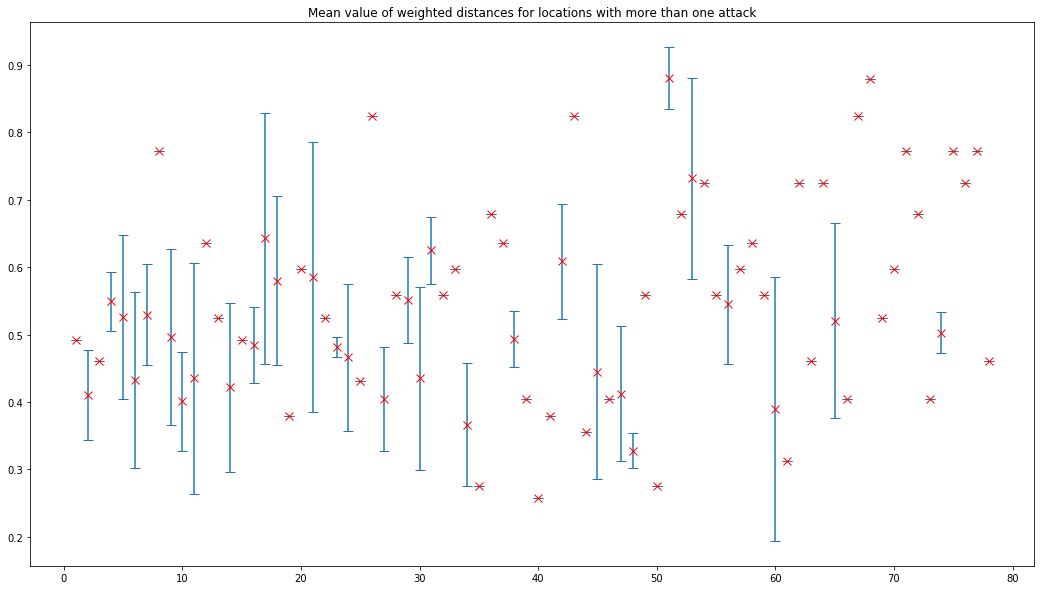

In [8]:
x = list(weights_dict.keys())
y = np.zeros(len(x))
yerr = np.zeros(len(x))
index = 0
for i in x:
    y[index] = weights_dict[i]['mean']
    yerr[index] = weights_dict[i]['std']
    index += 1

plt.figure(figsize=(18,10))
plt.errorbar(np.linspace(1,len(x),len(x)),y,yerr, linestyle='None',marker='x', markersize= 8,
                    markeredgecolor = [1,0,0],capsize=5)
plt.title('Mean value of weighted distances for locations with more than one attack')
plt.show()

In [134]:
def plot_recap_label(k):
    
    numb = np.size(recap_label[k])-1
    x = []
    y = []
    for i in range(0,numb):
        x.append(list(recap_label[k][i].keys()))
        y.append(list(recap_label[k][i].values()))
        
    x = [val for sublist in x for val in sublist]
    y = [val for sublist in y for val in sublist] 
    
    plt.bar(x,y)
    plt.show()
    return

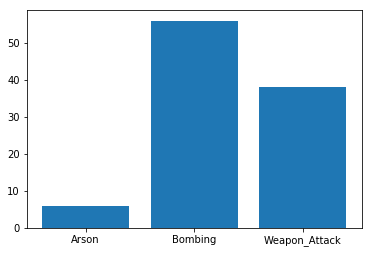

In [136]:
plot_recap_label(21)

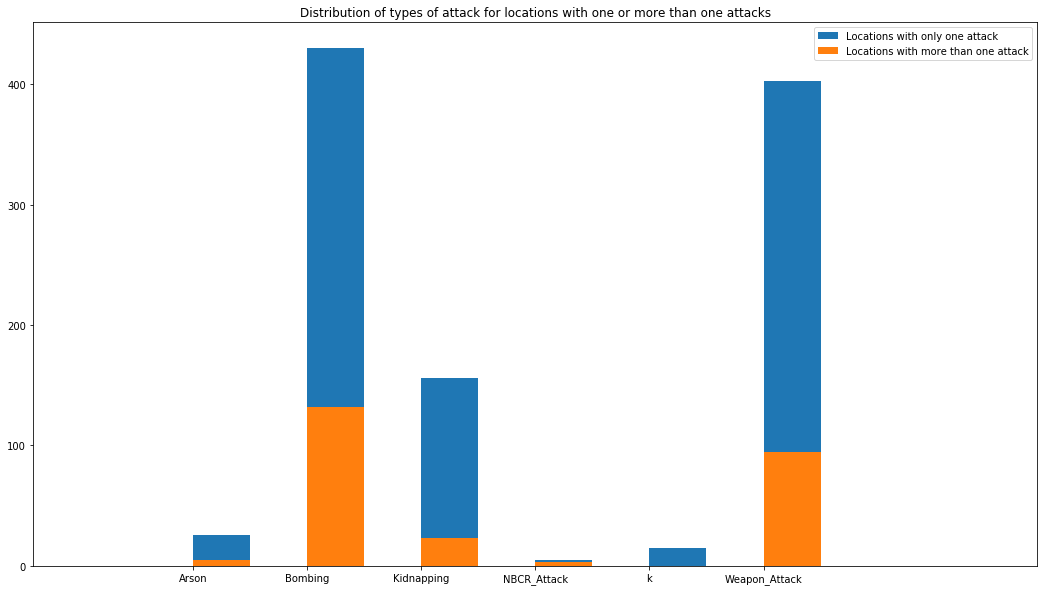

In [41]:
plt.figure(figsize=(18,10))
y_single_attack = np.take(labels,index_attack)
y_single_attack = np.reshape(y_single_attack,(y_single_attack.shape[0],1))

y_multiple_attack = np.delete(labels,index_attack)
y_multiple_attack = np.reshape(y_multiple_attack,(y_multiple_attack.shape[0],1))

plt.hist(y_multiple_attack, bins = np.linspace(-1,7,17))
plt.hist(y_single_attack, bins = np.linspace(-1,7,17))
plt.legend(('Locations with only one attack','Locations with more than one attack'))
plt.title('Distribution of types of attack for locations with one or more than one attacks')
plt.show()

##### **Remarks**

We see that the distribution of types of attack is almost the same between the locations with more than one attack (in orange) and the locations with only one attack (blue)